In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report


In [2]:

train_dir = "C:/Users/tugca/Desktop/Python/project_datasets/data/train"
test_dir = "C:/Users/tugca/Desktop/Python/project_datasets/data/test"


In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,              
    rotation_range=20,           
    width_shift_range=0.1,       
    height_shift_range=0.1,      
    shear_range=0.1,             
    zoom_range=0.1,              
    fill_mode='nearest'
) 
test_datagen = ImageDataGenerator(rescale=1./255)


In [30]:
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=32,         
    shuffle=True,
    class_mode='categorical'         
)


Found 2637 images belonging to 2 classes.


In [31]:

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224), 
    batch_size=32,         
    shuffle=False,
    class_mode='categorical'         
    
)


Found 660 images belonging to 2 classes.


In [43]:
learning_rate=1e-3
optim = 'adam'

model = Sequential([
    Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_uniform', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3),kernel_initializer='glorot_uniform',activation='relu'),
    BatchNormalization(),  
    MaxPooling2D((2, 2)),
    Dropout(0.2),  

    Flatten(),

    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(2, activation='softmax')  
])

if optim == 'rmsprop': 
    optimizer = RMSprop(learning_rate=learning_rate)
else:
    optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [44]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',   
    patience=5, 
    verbose=1, 
    factor=0.5, 
    min_lr=1e-7
)

In [45]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=3,  
    verbose=1,
    restore_best_weights=True  
)

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_18 (Bat  (None, 222, 222, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 111, 111, 64)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 batch_normalization_19 (Bat  (None, 109, 109, 64)    

In [47]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/30
83/83 [==============================] - 316s 4s/step - loss: 0.5809 - accuracy: 0.7672 - val_loss: 0.6033 - val_accuracy: 0.6652 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - 193s 2s/step - loss: 0.4721 - accuracy: 0.7899 - val_loss: 0.6094 - val_accuracy: 0.6788 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - 163s 2s/step - loss: 0.4574 - accuracy: 0.7850 - val_loss: 0.6616 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/30
83/83 [==============================] - 163s 2s/step - loss: 0.4278 - accuracy: 0.8089 - val_loss: 0.5285 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 5/30
83/83 [==============================] - 162s 2s/step - loss: 0.3956 - accuracy: 0.8077 - val_loss: 0.6360 - val_accuracy: 0.6197 - lr: 0.0010
Epoch 6/30
83/83 [==============================] - 161s 2s/step - loss: 0.3835 - accuracy: 0.8161 - val_loss: 0.4124 - val_accuracy: 0.7924 - lr: 0.0010
Epoch 7/30
83/83 [==============================] - 162s 2s/step - loss: 0.3

In [48]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test kaybı: {loss}")
print(f"Test doğruluğu: {accuracy}")

21/21 [==============================] - 7s 343ms/step - loss: 0.3553 - accuracy: 0.8409
Test kaybı: 0.3553009629249573
Test doğruluğu: 0.8409090638160706


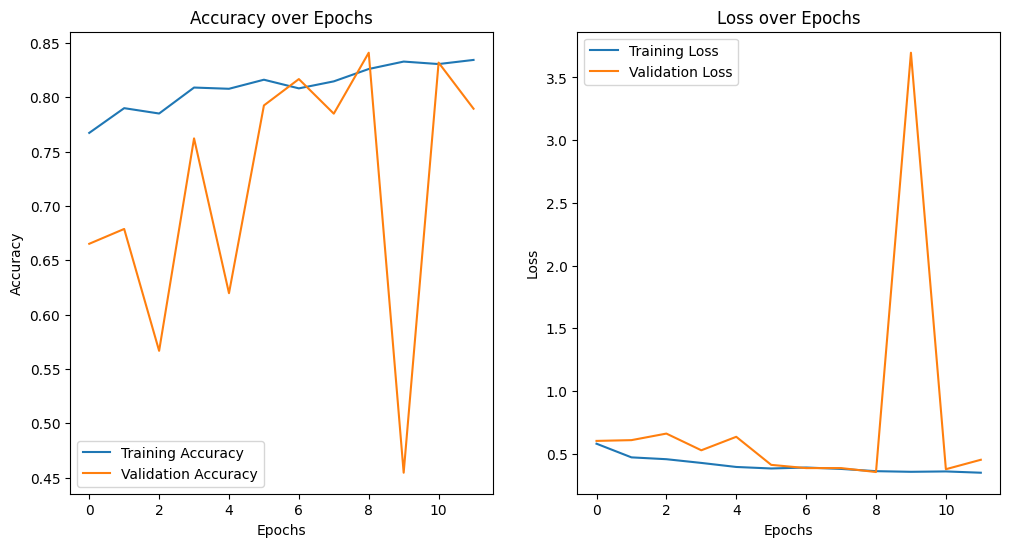

In [49]:
# Eğitim ve doğrulama kaybı ve doğruluk grafikleri
plt.figure(figsize=(12, 6))
# Doğruluk
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Kayıp
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

21/21 [==============================] - 7s 343ms/step


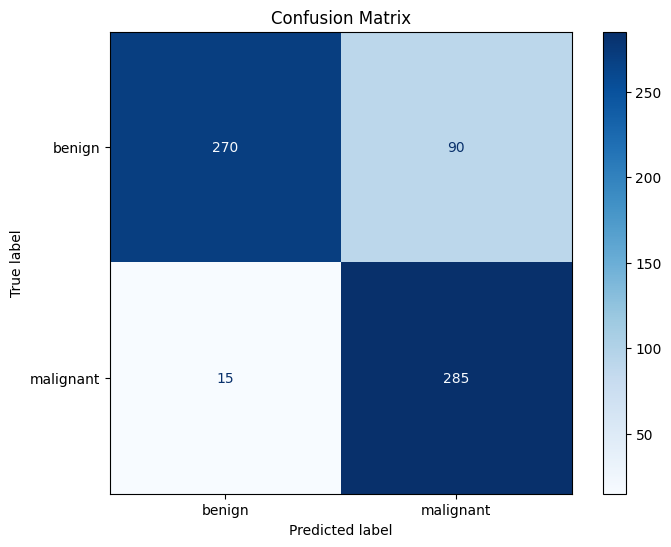

In [52]:
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)  # Softmax çıktısını sınıflara dönüştürme
y_true = test_dataset.classes  # Gerçek sınıflar

cm = confusion_matrix(y_true, y_pred)

labels = ['benign', 'malignant']  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [53]:
report = classification_report(y_true, y_pred, target_names=labels)
print(report)

# F1 skoru
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

              precision    recall  f1-score   support

      benign       0.95      0.75      0.84       360
   malignant       0.76      0.95      0.84       300

    accuracy                           0.84       660
   macro avg       0.85      0.85      0.84       660
weighted avg       0.86      0.84      0.84       660

F1 Score: 0.8404980032887011
